In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

**Load Data**

In [5]:
data = pd.read_csv("/content/drive/MyDrive/winemag-data_first150k.csv")
data

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...,...
150925,150925,Italy,Many people feel Fiano represents southern Ita...,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,150926,France,"Offers an intriguing nose with ginger, lime an...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,150927,Italy,This classic example comes from a cru vineyard...,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,150928,France,"A perfect salmon shade, with scents of peaches...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


**Data Cleaning and  Imputing of null values**

In [6]:
#drop the index column
data=data.drop(columns=['Unnamed: 0'])
data["price"].describe()

count    137235.000000
mean         33.131482
std          36.322536
min           4.000000
25%          16.000000
50%          24.000000
75%          40.000000
max        2300.000000
Name: price, dtype: float64

In [7]:
data['description'].isna().sum()

0

In [8]:
# drop null and duplicate values
data.dropna(subset=['price', "points"], inplace=True)
data.drop_duplicates(subset=['description'], inplace=True)
data.nunique()

country           46
description    89108
designation    28345
points            21
price            357
province         446
region_1        1197
region_2          18
variety          619
winery         13852
dtype: int64

In [9]:
#replace nan values for text features with empty string
data[['country', 'designation', 'region_1', 'region_2', 'province', 'variety', 'winery']] = data[['country','designation', 'region_1', 'region_2', 'province', 'variety', 'winery']].fillna("")
data.isnull().sum()

country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
variety        0
winery         0
dtype: int64

In [10]:
four_bins = pd.qcut(data["price"], q=4)
print(four_bins)

two_bins = pd.qcut(data["price"], q=2)
print(two_bins)

0         (40.0, 2300.0]
1         (40.0, 2300.0]
2         (40.0, 2300.0]
3         (40.0, 2300.0]
4         (40.0, 2300.0]
               ...      
149634     (3.999, 16.0]
149635     (3.999, 16.0]
149637     (3.999, 16.0]
149638     (3.999, 16.0]
149639     (3.999, 16.0]
Name: price, Length: 89108, dtype: category
Categories (4, interval[float64, right]): [(3.999, 16.0] < (16.0, 25.0] < (25.0, 40.0] <
                                           (40.0, 2300.0]]
0         (25.0, 2300.0]
1         (25.0, 2300.0]
2         (25.0, 2300.0]
3         (25.0, 2300.0]
4         (25.0, 2300.0]
               ...      
149634     (3.999, 25.0]
149635     (3.999, 25.0]
149637     (3.999, 25.0]
149638     (3.999, 25.0]
149639     (3.999, 25.0]
Name: price, Length: 89108, dtype: category
Categories (2, interval[float64, right]): [(3.999, 25.0] < (25.0, 2300.0]]


In [11]:
four_categories = four_bins.cat.categories.tolist()
four_target_names = [str(i) for i in four_categories]

two_categories = two_bins.cat.categories.tolist()
two_target_names = [str(i) for i in two_categories]

In [12]:
data["four_price_categorical"] = four_bins.cat.codes
data["two_price_categorical"] = two_bins.cat.codes
data

,country,description,designation,points,price,province,region_1,region_2,variety,winery,four_price_categorical,two_price_categorical
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,3,1
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,,Tinta de Toro,Bodega Carmen Rodríguez,3,1
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,3,1
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,3,1
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,,Provence red blend,Domaine de la Bégude,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
149634,France,Atypically light in body and reticent on the n...,,84,15.0,Alsace,Alsace,,Gewürztraminer,W. Gisselbrecht,0,0
149635,US,A Syrah-Grenache blend that's dry and rustical...,Bungalow Red,84,15.0,California,Santa Barbara County,Central Coast,Syrah-Grenache,Casa Barranca,0,0
149637,US,"Outside of the vineyard, wines like this are w...",,84,6.0,California,California,California Other,Merlot,Delicato,0,0
149638,Argentina,"Heavy and basic, with melon and pineapple arom...",,84,9.0,Mendoza Province,Uco Valley,,Sauvignon Blanc,Finca El Portillo,0,0


In [13]:
data['description'] = data['description'].astype(str)
data['description_noDigits'] = data['description'].str.replace(r'\d', '', regex=True)

**10,000 sample predictions**

In [14]:
data_selection = 10000
four_sample_data = data.sample(data_selection, random_state=1)
two_sample_data = data.sample(data_selection, random_state=1)
# (train_texts, test_texts, train_labels, test_labels) = train_test_split(list(data["description_features"][:data_selection]), list(df["price_categorical"][:data_selection]), test_size=0.2, stratify=list(df["price_categorical"][:data_selection]), random_state=1)

(four_train_data, four_test_data) = train_test_split(four_sample_data, test_size=0.2, random_state=1)
(two_train_data, two_test_data) = train_test_split(two_sample_data, test_size=0.2, random_state=1)

In [15]:
# (train_texts, valid_texts, train_labels, valid_labels) = train_test_split(train_texts, train_labels, test_size=0.25, stratify=train_labels, random_state=1)
# type(train_texts)

(four_train_data, four_valid_data) = train_test_split(four_train_data, test_size=0.25, random_state=1)
(two_train_data, two_valid_data) = train_test_split(two_train_data, test_size=0.25, random_state=1)


In [16]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [17]:
four_percs = pd.qcut(four_train_data["description_noDigits"].str.len(), q=10)
print(four_percs)

two_percs = pd.qcut(two_train_data["description_noDigits"].str.len(), q=10)
print(two_percs)

49592      (221.0, 236.0]
50783      (204.0, 221.0]
149343     (269.0, 294.0]
59602      (330.0, 681.0]
111711     (157.0, 184.0]
               ...       
81854      (157.0, 184.0]
56561      (252.0, 269.0]
56273      (157.0, 184.0]
37331     (32.999, 157.0]
105197     (184.0, 204.0]
Name: description_noDigits, Length: 6000, dtype: category
Categories (10, interval[float64, right]): [(32.999, 157.0] < (157.0, 184.0] < (184.0, 204.0] <
                                            (204.0, 221.0] ... (252.0, 269.0] < (269.0, 294.0] <
                                            (294.0, 330.0] < (330.0, 681.0]]
49592      (221.0, 236.0]
50783      (204.0, 221.0]
149343     (269.0, 294.0]
59602      (330.0, 681.0]
111711     (157.0, 184.0]
               ...       
81854      (157.0, 184.0]
56561      (252.0, 269.0]
56273      (157.0, 184.0]
37331     (32.999, 157.0]
105197     (184.0, 204.0]
Name: description_noDigits, Length: 6000, dtype: category
Categories (10, interval[float64, right]):

In [18]:
four_max_length = 280
two_max_length = 280

In [19]:
def create_bert_model(bert_model,
                      experiment,
                      num_classes=4,
                      hidden_size = 256,
                      dropout=0.3,
                      learning_rate=1e-5):

    bert_model.trainable = True

    if experiment == "two class":
      input_ids = tf.keras.layers.Input(shape=(two_max_length,), dtype=tf.int64, name='input_ids_layer')
      token_type_ids = tf.keras.layers.Input(shape=(two_max_length,), dtype=tf.int64, name='token_type_ids_layer')
      attention_mask = tf.keras.layers.Input(shape=(two_max_length,), dtype=tf.int64, name='attention_mask_layer')
    else:
      input_ids = tf.keras.layers.Input(shape=(four_max_length,), dtype=tf.int64, name='input_ids_layer')
      token_type_ids = tf.keras.layers.Input(shape=(four_max_length,), dtype=tf.int64, name='token_type_ids_layer')
      attention_mask = tf.keras.layers.Input(shape=(four_max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]
    dropout_layer = tf.keras.layers.Dropout(dropout)(cls_token)
    hidden_layer = tf.keras.layers.Dense(hidden_size, activation='swish', name='hidden_layer')(dropout_layer)
    hidden_layer_2 = tf.keras.layers.Dense(hidden_size/2, activation='swish', name='hidden_layer_2')(hidden_layer)

    if experiment == "two class":
      classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden_layer_2)
      classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
      classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = 'binary_crossentropy',
              metrics = 'accuracy')
    else:
      classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden_layer_2)
      classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
      classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')

    return classification_model

In [20]:
four_cls_bert_model = create_bert_model(bert_model, experiment="four class")

four_nptrain_labels = np.asarray(four_train_data['four_price_categorical'])
four_npvalid_labels = np.asarray(four_valid_data['four_price_categorical'])
four_nptest_labels = np.asarray(four_test_data['four_price_categorical'])

train_encodings = bert_tokenizer(list(four_train_data['description_noDigits']), truncation=True, padding="max_length", max_length=four_max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(four_valid_data['description_noDigits']), truncation=True, padding="max_length", max_length=four_max_length, return_tensors='tf')
four_test_encodings = bert_tokenizer(list(four_test_data['description_noDigits']), truncation=True, padding="max_length", max_length=four_max_length, return_tensors='tf')

four_cls_bert_model_history_10k = four_cls_bert_model.fit(x=[train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                              y=four_nptrain_labels,
                                              validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                              four_npvalid_labels),
                                              shuffle=True,
                                              batch_size=8,
                                              validation_batch_size=8,
                                              epochs=4)

predictions = four_cls_bert_model.predict([four_test_encodings.input_ids, four_test_encodings.token_type_ids, four_test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(four_nptest_labels, predictions.numpy(), target_names=four_target_names))

four_test_score = four_cls_bert_model.evaluate([four_test_encodings.input_ids, four_test_encodings.token_type_ids, four_test_encodings.attention_mask],
                                                  four_nptest_labels)

print('Four-class 10k test loss:', four_test_score[0])
print('Four-class 10k test accuracy:', four_test_score[1])

Epoch 1/4


750/750 [==============================] - 498s 606ms/step - loss: 1.2762 - accuracy: 0.3843 - val_loss: 1.1873 - val_accuracy: 0.4470
Epoch 2/4
750/750 [==============================] - 445s 593ms/step - loss: 1.1122 - accuracy: 0.4900 - val_loss: 1.1896 - val_accuracy: 0.4370
Epoch 3/4
750/750 [==============================] - 444s 592ms/step - loss: 0.9616 - accuracy: 0.5673 - val_loss: 1.2626 - val_accuracy: 0.4530
Epoch 4/4
63/63 [==============================] - 45s 670ms/step
                precision    recall  f1-score   support

 (3.999, 16.0]       0.56      0.66      0.60       569
  (16.0, 25.0]       0.35      0.42      0.38       511
  (25.0, 40.0]       0.34      0.32      0.33       426
(40.0, 2300.0]       0.60      0.39      0.47       494

      accuracy                           0.46      2000
     macro avg       0.46      0.45      0.45      2000
  weighted avg       0.47      0.46      0.46      2000

63/63 [==============================] - 44s 651ms/step - 

In [21]:
two_cls_bert_model = create_bert_model(bert_model, experiment="two class")

two_nptrain_labels = np.asarray(two_train_data['two_price_categorical'])
two_npvalid_labels = np.asarray(two_valid_data['two_price_categorical'])
two_nptest_labels = np.asarray(two_test_data['two_price_categorical'])

train_encodings = bert_tokenizer(list(two_train_data['description_noDigits']), truncation=True, padding="max_length", max_length=two_max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(two_valid_data['description_noDigits']), truncation=True, padding="max_length", max_length=two_max_length, return_tensors='tf')
two_test_encodings = bert_tokenizer(list(two_test_data['description_noDigits']), truncation=True, padding="max_length", max_length=two_max_length, return_tensors='tf')

two_cls_bert_model_history_10k = two_cls_bert_model.fit(x=[train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                              y=two_nptrain_labels,
                                              validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                              two_npvalid_labels),
                                              shuffle=True,
                                              batch_size=8,
                                              validation_batch_size=8,
                                              epochs=4)

predictions = two_cls_bert_model.predict([two_test_encodings.input_ids, two_test_encodings.token_type_ids, two_test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(two_nptest_labels, predictions.numpy(), target_names=two_target_names))

two_test_score = two_cls_bert_model.evaluate([two_test_encodings.input_ids, two_test_encodings.token_type_ids, two_test_encodings.attention_mask],
                                                  two_nptest_labels)

print('Two-class 10k test loss:', two_test_score[0])
print('Two-class 10k test accuracy:', two_test_score[1])

Epoch 1/4


750/750 [==============================] - 450s 543ms/step - loss: 0.2674 - accuracy: 0.8847 - val_loss: 0.7606 - val_accuracy: 0.7035
Epoch 2/4
750/750 [==============================] - 403s 537ms/step - loss: 0.1372 - accuracy: 0.9480 - val_loss: 1.0711 - val_accuracy: 0.7040
Epoch 3/4
750/750 [==============================] - 402s 537ms/step - loss: 0.0859 - accuracy: 0.9725 - val_loss: 1.1454 - val_accuracy: 0.6990
Epoch 4/4
63/63 [==============================] - 45s 671ms/step
                precision    recall  f1-score   support

 (3.999, 25.0]       0.54      1.00      0.70      1080
(25.0, 2300.0]       0.00      0.00      0.00       920

      accuracy                           0.54      2000
     macro avg       0.27      0.50      0.35      2000
  weighted avg       0.29      0.54      0.38      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63/63 [==============================] - 44s 652ms/step - loss: 1.3879 - accuracy: 0.7340
Two-class 10k test loss: 1.387879729270935
Two-class 10k test accuracy: 0.734000027179718


**20,000 sample predictions**

In [22]:
data_selection = 20000
four_sample_data = data.sample(data_selection, random_state=1)
two_sample_data = data.sample(data_selection, random_state=1)
# (train_texts, test_texts, train_labels, test_labels) = train_test_split(list(data["description_features"][:data_selection]), list(df["price_categorical"][:data_selection]), test_size=0.2, stratify=list(df["price_categorical"][:data_selection]), random_state=1)

(four_train_data, four_test_data) = train_test_split(four_sample_data, test_size=0.2, random_state=1)
(two_train_data, two_test_data) = train_test_split(two_sample_data, test_size=0.2, random_state=1)

In [23]:
# (train_texts, valid_texts, train_labels, valid_labels) = train_test_split(train_texts, train_labels, test_size=0.25, stratify=train_labels, random_state=1)
# type(train_texts)

(four_train_data, four_valid_data) = train_test_split(four_train_data, test_size=0.25, random_state=1)
(two_train_data, two_valid_data) = train_test_split(two_train_data, test_size=0.25, random_state=1)


In [24]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [25]:
four_percs = pd.qcut(four_train_data["description_noDigits"].str.len(), q=10)
print(four_percs)

two_percs = pd.qcut(two_train_data["description_noDigits"].str.len(), q=10)
print(two_percs)

143931     (157.0, 185.0]
88758      (294.0, 330.0]
100386     (294.0, 330.0]
6128       (157.0, 185.0]
31926      (157.0, 185.0]
               ...       
70132      (330.0, 695.0]
9659       (204.0, 221.0]
111723    (19.999, 157.0]
78773      (204.0, 221.0]
98078      (253.0, 271.0]
Name: description_noDigits, Length: 12000, dtype: category
Categories (10, interval[float64, right]): [(19.999, 157.0] < (157.0, 185.0] < (185.0, 204.0] <
                                            (204.0, 221.0] ... (253.0, 271.0] < (271.0, 294.0] <
                                            (294.0, 330.0] < (330.0, 695.0]]
143931     (157.0, 185.0]
88758      (294.0, 330.0]
100386     (294.0, 330.0]
6128       (157.0, 185.0]
31926      (157.0, 185.0]
               ...       
70132      (330.0, 695.0]
9659       (204.0, 221.0]
111723    (19.999, 157.0]
78773      (204.0, 221.0]
98078      (253.0, 271.0]
Name: description_noDigits, Length: 12000, dtype: category
Categories (10, interval[float64, right]

In [26]:
four_max_length = 280
two_max_length = 280

In [27]:
def create_bert_model(bert_model,
                      experiment,
                      num_classes=4,
                      hidden_size = 256,
                      dropout=0.3,
                      learning_rate=1e-5):

    bert_model.trainable = True

    if experiment == "two class":
      input_ids = tf.keras.layers.Input(shape=(two_max_length,), dtype=tf.int64, name='input_ids_layer')
      token_type_ids = tf.keras.layers.Input(shape=(two_max_length,), dtype=tf.int64, name='token_type_ids_layer')
      attention_mask = tf.keras.layers.Input(shape=(two_max_length,), dtype=tf.int64, name='attention_mask_layer')
    else:
      input_ids = tf.keras.layers.Input(shape=(four_max_length,), dtype=tf.int64, name='input_ids_layer')
      token_type_ids = tf.keras.layers.Input(shape=(four_max_length,), dtype=tf.int64, name='token_type_ids_layer')
      attention_mask = tf.keras.layers.Input(shape=(four_max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]
    dropout_layer = tf.keras.layers.Dropout(dropout)(cls_token)
    hidden_layer = tf.keras.layers.Dense(hidden_size, activation='swish', name='hidden_layer')(dropout_layer)
    hidden_layer_2 = tf.keras.layers.Dense(hidden_size/2, activation='swish', name='hidden_layer_2')(hidden_layer)

    if experiment == "two class":
      classification = tf.keras.layers.Dense(2, activation='softmax',name='classification_layer')(hidden_layer_2)
      classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
      classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')
    else:
      classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden_layer_2)
      classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
      classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')

    return classification_model

In [28]:
four_cls_bert_model = create_bert_model(bert_model, experiment="four class")

four_nptrain_labels = np.asarray(four_train_data['four_price_categorical'].astype('int64'))
four_npvalid_labels = np.asarray(four_valid_data['four_price_categorical'].astype('int64'))
four_nptest_labels = np.asarray(four_test_data['four_price_categorical'].astype('int64'))

train_encodings = bert_tokenizer(list(four_train_data['description_noDigits']), truncation=True, padding="max_length", max_length=four_max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(four_valid_data['description_noDigits']), truncation=True, padding="max_length", max_length=four_max_length, return_tensors='tf')
four_test_encodings = bert_tokenizer(list(four_test_data['description_noDigits']), truncation=True, padding="max_length", max_length=four_max_length, return_tensors='tf')

four_cls_bert_model_history_20k = four_cls_bert_model.fit(x=[train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                              y=four_nptrain_labels,
                                              validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                              four_npvalid_labels),
                                              shuffle=True,
                                              batch_size=8,
                                              validation_batch_size=8,
                                              epochs=4)

predictions = four_cls_bert_model.predict([four_test_encodings.input_ids, four_test_encodings.token_type_ids, four_test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(four_nptest_labels, predictions.numpy(), target_names=four_target_names))

four_test_score = four_cls_bert_model.evaluate([four_test_encodings.input_ids, four_test_encodings.token_type_ids, four_test_encodings.attention_mask],
                                                  four_nptest_labels)

print('Four-class 20k test loss:', four_test_score[0])
print('Four-class 20k test accuracy:', four_test_score[1])

Epoch 1/4


1500/1500 [==============================] - 853s 540ms/step - loss: 1.2216 - accuracy: 0.4265 - val_loss: 1.1181 - val_accuracy: 0.4770
Epoch 2/4
1500/1500 [==============================] - 863s 576ms/step - loss: 1.0762 - accuracy: 0.5097 - val_loss: 1.0893 - val_accuracy: 0.4927
Epoch 3/4
1500/1500 [==============================] - 864s 576ms/step - loss: 0.9425 - accuracy: 0.5803 - val_loss: 1.1199 - val_accuracy: 0.4870
Epoch 4/4
125/125 [==============================] - 83s 646ms/step
                precision    recall  f1-score   support

 (3.999, 16.0]       0.61      0.60      0.61      1104
  (16.0, 25.0]       0.36      0.45      0.40      1020
  (25.0, 40.0]       0.37      0.35      0.36       905
(40.0, 2300.0]       0.61      0.50      0.55       971

      accuracy                           0.48      4000
     macro avg       0.49      0.48      0.48      4000
  weighted avg       0.49      0.48      0.49      4000

125/125 [==============================] - 87s 662

In [29]:
two_cls_bert_model = create_bert_model(bert_model, experiment="two class")

two_nptrain_labels = np.asarray(two_train_data['two_price_categorical'].astype('int64'))
two_npvalid_labels = np.asarray(two_valid_data['two_price_categorical'].astype('int64'))
two_nptest_labels = np.asarray(two_test_data['two_price_categorical'].astype('int64'))

train_encodings = bert_tokenizer(list(two_train_data['description_noDigits']), truncation=True, padding="max_length", max_length=two_max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(two_valid_data['description_noDigits']), truncation=True, padding="max_length", max_length=two_max_length, return_tensors='tf')
two_test_encodings = bert_tokenizer(list(two_test_data['description_noDigits']), truncation=True, padding="max_length", max_length=two_max_length, return_tensors='tf')

two_cls_bert_model_history_20k = two_cls_bert_model.fit(x=[train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                              y=two_nptrain_labels,
                                              validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                              two_npvalid_labels),
                                              shuffle=True,
                                              batch_size=8,
                                              validation_batch_size=8,
                                              epochs=4)

predictions = two_cls_bert_model.predict([two_test_encodings.input_ids, two_test_encodings.token_type_ids, two_test_encodings.attention_mask])
predictions = tf.argmax(predictions, axis=-1)
print(classification_report(two_nptest_labels, predictions.numpy(), target_names=two_target_names))

two_test_score = two_cls_bert_model.evaluate([two_test_encodings.input_ids, two_test_encodings.token_type_ids, two_test_encodings.attention_mask],
                                                  two_nptest_labels)

print('Two-class 20k test loss:', two_test_score[0])
print('Two-class 20k test accuracy:', two_test_score[1])

Epoch 1/4


1500/1500 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.8878

KeyboardInterrupt: ignored

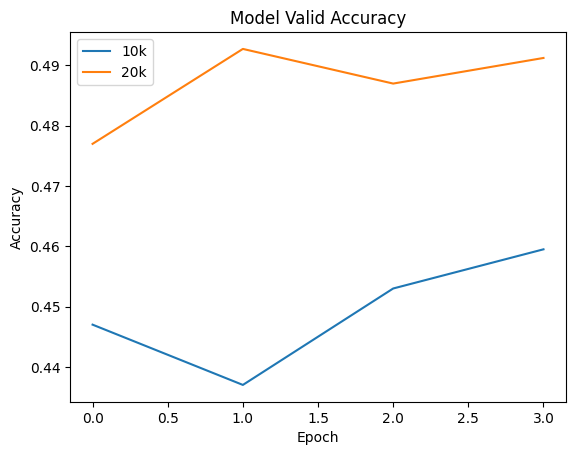

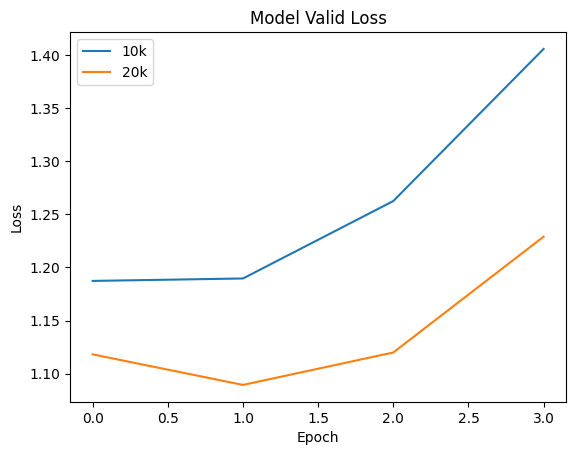

In [30]:
# Valid accuracy comparison between 10k and 20k
plt.plot(four_cls_bert_model_history_10k.history['val_accuracy'])
plt.plot(four_cls_bert_model_history_20k.history['val_accuracy'])
plt.title('Model Valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['10k', '20k'], loc='upper left')
plt.show()

# Valid loss comparison between 10k and 20k
plt.plot(four_cls_bert_model_history_10k.history['val_loss'])
plt.plot(four_cls_bert_model_history_20k.history['val_loss'])
plt.title('Model Valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['10k', '20k'], loc='upper left')
plt.show()